In [7]:
import time

from qunetsim.components.host import Host
from qunetsim.components.network import Network
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
import random
import numpy as np
import matplotlib.pyplot as plt


wins = 0


In [8]:

def retrun_array(gate):
        theta = gate.params[0]
        if gate.name=='rx':
                return np.array([[np.cos(theta/2), -1j*np.sin(theta/2)],[-1j*np.sin(theta/2), np.cos(theta/2)]])
        elif gate.name=='ry':
                return np.array([[np.cos(theta/2), -np.sin(theta/2)],[np.sin(theta/2), np.cos(theta/2)]])
        elif gate.name=='z':
                return np.array([[np.exp(-1j*theta/2), 0],[0, np.exp(1j*theta/2)]])
        else:
                return np.eye(2)


def referee(host, players, game_type):
        global wins

        # Reset the classical message buffer
        host.empty_classical()

        # If the game type is quantum, then the referee will distribute GHZ states
        # for simplicity
        if game_type == 'q':
                # Distribute a GHZ state to the players
                print('Referee: sending ghz')
                host.send_ghz(players, distribute=True, await_ack=False, no_ack=True)
                print('Referee: done sending ghz')

        # Referee sends te random bit to each player
        print('Referee: sending classical messages')
        sent = []
        for p in players:
                sent.append(random.choice([0, 1]))
                host.send_classical(p, sent[-1], await_ack=False, no_ack=True)
        print('Referee: done sending classical messages')

        # Referee collects all responses
        print('Referee: waiting for responses')
        responses = []
        for p in players:
                responses.append(host.get_classical(p, wait=10)[0].content)
        print('Referee: got all responses')

        # Referee determines the winning condition based on the sent bits
        w = 0 if sum(sent) % 4 in [0, 1] else 1

        # Compute the joint XOR
        a = 0
        # TODO: Compute the joint XOR over all responses

        xor_final = 0
        for i in responses:
                cor_final = xor_final^i

        # Determine if the players have won
        # TODO: Determine the correct winning condition
        if xor_final==w:
                wins += 1
                print('Referee: winners')
        else:
                print('Referee: losers')



In [9]:


def classical_player(host, ref):
        # Reset the classical message buffer
        host.empty_classical()
        x = host.get_classical(ref, wait=10)[0].content
        print('Player %s: received message %d' % (host.host_id, x))

        # TODO: Correct the classical strategy
        # x = random.choice([0, 1])
        x = 0
        host.send_classical(ref, x, no_ack=True)


In [10]:

def quantum_player(host, ref, angle):
        # Reset the classical message buffer
        host.empty_classical()

        # Receive the GHZ state
        # (creating simulated GHZ states is a bit time consuming,
        # therefore the max wait value needs to be relatively large)
        q = host.get_ghz(ref, wait=15)
        assert q is not None

        print('Player %s: got ghz' % host.host_id)
        x = host.get_classical(ref, wait=10)[0].content
        print('Player %s: got classical message %d' % (host.host_id, x))

        # TODO: Use the correct unitary according to the optimal
        #           quantum strategy

        # Hint: rotation operations can be performed on a qubit
        #           using q.rx(angle), q.ry(angle), q.rz(angle)

        # Perform the correct unitary operation
        if x == 0:
                a = np.exp(1j*(np.pi/2 + angle))
        else:
                a = np.exp(1j*angle)
        u = (1 / np.sqrt(2)) * np.array([[a, 1], [-1, 1 / a]])

        decomposition = True
        if(decomposition == False):
                # without decomposition
                q.custom_gate(u)
        else:
                # with decomposition
                qc = QuantumCircuit(1)
                qc.unitary(u, qubits = qc.qubits, label = "U")
                target_basis = ['rx', 'ry', 'rz']
                decomposed = transpile(qc,
                                basis_gates=target_basis, 
                                optimization_level=0)
                array_of_operators = []
                for gate in decomposed.data:
                        array_of_operators.append(retrun_array(gate[0]))
                for i in reversed(array_of_operators):
                        q.custom_gate(i)
        host.send_classical(ref, q.measure(), no_ack=True)


Game 1 starting
Referee: sending ghz
Referee: done sending ghz
Referee: sending classical messages
Referee: done sending classical messages
Referee: waiting for responses
Player F: got ghz
Player G: got ghz
Player B: got ghz
Player D: got ghz
Player C: got ghz
Player E: got ghz
Player H: got ghz
Player A: got ghz
Player A: got classical message 1
Player B: got classical message 1
Player C: got classical message 1
Player D: got classical message 1
Player E: got classical message 0
Player F: got classical message 1
Player H: got classical message 0
Player G: got classical message 1
Referee: got all responses
Referee: losers
Game 1 ended
Game 2 starting
Referee: sending ghz
Referee: done sending ghz
Referee: sending classical messages
Referee: done sending classical messages
Referee: waiting for responses
Player B: got ghz
Player F: got ghz
Player E: got ghz
Player D: got ghz
Player G: got ghz
Player A: got ghz
Player C: got ghz
Player H: got ghz
Player B: got classical message 0
Player A

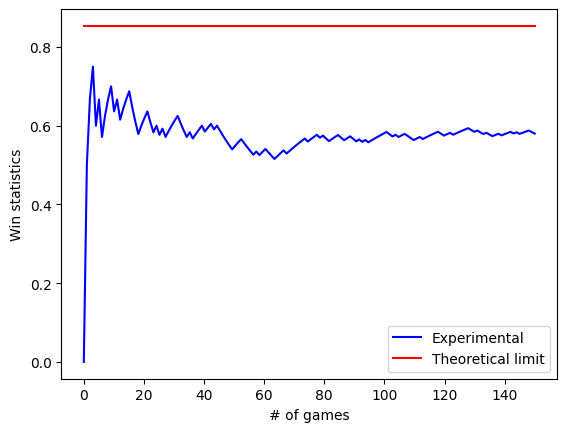

In [11]:


def main():
        # Get and start the network
        network = Network.get_instance()
        network.start()
        network.delay = 0.0

        ids = 'ABCDEFGHIJKLMNOP'
        players = []

        # Initiate the referee host
        ref = Host('Ref')
        ref.start()

        # Select the strategy for the simulation
        # classical
        # strategy = 'c'

        # quantum
        strategy = 'q'

        # Number of players
        n = 8

        if n > len(ids):
                raise Exception("Not enough IDs")

        # Add the players to the network
        for i in range(n):
                host = Host(ids[i])
                host.add_connection('Ref')
                ref.add_connection(ids[i])
                players.append(host)
                host.start()

        # Add the hosts to the network
        network.add_hosts(players)
        network.add_host(ref)

        # How many times to play the game
        plays = 150

        # TODO: Find the correct angle for the number of players
        # Calculate the angle for the players
        angle = ((2*n + 1) % 8)/4/n*np.pi

        # Small optimization for classical case
        if strategy == 'c':
                ref.delay = 0
                for player in players:
                        player.delay = 0

        p_array = []

        # Run the game
        for i in range(plays):
                print("Game %d starting" % (i + 1))
                for player in players:
                        if strategy == 'q':
                                player.run_protocol(quantum_player, (ref.host_id, angle))
                        else:
                                player.run_protocol(classical_player, (ref.host_id,))

                ref.run_protocol(referee, ([player.host_id for player in players], strategy),
                                                        blocking=True)
                print("Game %d ended" % (i + 1))
                p_array.append((wins / (i+1)))


        if strategy == 'q':
                p = 1 / 2 + 1 / (2 * np.sqrt(2))
        else:
                p = 1 / 2 + 1 / 2 ** (n / 2)

        print("Win percentage was: %.3f" % (wins / plays))
        print("Optimal is %.3f" % p)
        network.stop(True)

# compare with theoretical results
# Ex1
        # x = np.linspace(0,plays, len(p_array))
        # y_teor = []
        # for i in x:
        #         y_teor.append(1.0 / 2.0 + 1.0 / (2.0**((n+1.0)/2.0)))
        # print((y_teor))

        # plt.figure()
        # plt.plot(x, p_array,color='b', label="Experimental")
        # plt.plot(x, y_teor, color='r', label="Theoretical limit")
        # plt.ylabel('Ex 1: Comparing theoretical and experimental results')
        # plt.legend()
        # plt.xlabel("# of games")
        # plt.ylabel("Win statistics")
        # plt.show()

# Ex2
        x = np.linspace(0,plays, len(p_array))
        y_teor = []
        for i in x:
                y_teor.append(1.0 / 2.0 + 1.0 / (2.0*np.sqrt(2.0)))
        print((y_teor))

        plt.figure()
        plt.plot(x, p_array,color='b', label="Experimental")
        plt.plot(x, y_teor, color='r', label="Theoretical limit")
        plt.ylabel('Ex 2: Comparing theoretical and experimental results')
        plt.legend()
        plt.xlabel("# of games")
        plt.ylabel("Win statistics")
        plt.show()


if __name__ == '__main__':
        main()


In [12]:
import numpy as np
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

n=8
angle = ((2*n + 1) % 8)/4/n*np.pi
a = np.exp(1j*angle)
U = (1 / np.sqrt(2)) * np.array([[a, 1], [-1, 1 / a]])
qc = QuantumCircuit(1)
qc.unitary(U, qubits = qc.qubits, label = "U")

target_basis = ['rx', 'ry', 'rz']
decomposed = transpile(qc,
                       basis_gates=target_basis, 
                       optimization_level=0)

for gate in decomposed.data:
    print('\ngate name:', gate[0].name)
    print('qubit(s) acted on:', gate[1])
    print('other paramters (such as angles):', gate[0].params)
print(decomposed.data)

decomposed.draw()


gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(1, 'q'), 0)]
other paramters (such as angles): [3.0434178831651124]

gate name: ry
qubit(s) acted on: [Qubit(QuantumRegister(1, 'q'), 0)]
other paramters (such as angles): [1.5707963267948966]

gate name: rz
qubit(s) acted on: [Qubit(QuantumRegister(1, 'q'), 0)]
other paramters (such as angles): [3.0434178831651124]
[CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.0434178831651124]), qubits=(Qubit(QuantumRegister(1, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='ry', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(Qubit(QuantumRegister(1, 'q'), 0),), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.0434178831651124]), qubits=(Qubit(QuantumRegister(1, 'q'), 0),), clbits=())]


global phase: π
   ┌────────────┐┌─────────┐┌────────────┐
q: ┤ Rz(3.0434) ├┤ Ry(π/2) ├┤ Rz(3.0434) ├
   └────────────┘└─────────┘└────────────┘